### BASE DE DATOS DE SPOTIFY

---

##### Trabajo practico I - Analisis predictivo avanzado
##### *Modelo final*




### PASO 1: Importamos las librerias que utilizaremos

In [ ]:
!pip install langdetect
!pip install scikit-optimize

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 7.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993224 sha256=42ee957ab450eb408fc98de570dfdb136af378c957c6fe61b7627498e5cdc0e5
  Stored in directory: /root/.cache/pip/wheels/95/03/7d/59ea870c70ce4e5a370638b5462a7711ab78fba2f655d05106
Successfully built langdetect
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 1.9 MB/s eta 0:00:00


In [ ]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 7.8 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import requests
import warnings
import openpyxl
import datetime
import pytz
import matplotlib as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import numpy as np
from langdetect import detect
from collections import defaultdict
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.metrics import auc, RocCurveDisplay
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from hyperopt import fmin, tpe, hp, Trials
from skopt import BayesSearchCV
import shap
from matplotlib.lines import Line2D


Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


### PASO 2: cargar el dataset

In [ ]:
# CARGAMOS EL DATASET #
df = pd.read_csv('/content/train.csv')

# ELIMINAMOS LA COLUMNA 0 YA Q NO ES RELEVANTE A NUESTRO ANALISIS #
df = df.drop(df.columns[0], axis=1)

In [ ]:
# AGREGAR LA COLUMNA IDIOMA DE LA CANCION #
# esto tarda media hora en correr, pero corre
def detect_language(text):
    if len(text.strip()) < 3:
        return 'Desconocido'
    try:
        return detect(text)
    except:
        return 'Desconocido'
df['Idioma_Detectado'] = df['name'].apply(detect_language)

In [ ]:
# BORRAR LA COLUMNA NAME #
df.drop(columns=['name'], inplace=True)

### PASO 3: particion entrenamiento y testeo

In [ ]:
y = df['popularity']
X = df.drop('popularity', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### PASO 4: armar el Pipeline

In [ ]:
class FeatureSelectionFrequencyEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, selected_features):
        self.selected_features = selected_features
        self.encoding_dict = defaultdict(int)

    def fit(self, X, y=None):
        for feature in self.selected_features:
                frequencies = X[feature].value_counts().to_dict()
                self.encoding_dict[feature] = frequencies

        return self

    def transform(self, X):
        X_copy = X.copy()
        for feature in self.selected_features:
            if feature in self.encoding_dict:
                X_copy[feature] = X_copy[feature].map(self.encoding_dict[feature])
        return X_copy


In [ ]:
class AgregarArtistasInvolucrados(BaseEstimator, TransformerMixin):
    def __init__(self, selected_features):
        self.selected_features = selected_features

    def fit(self, X, y=None):

        return self

    def transform(self, X):
        X_copy = X.copy()
        for feature in self.selected_features:
          X_copy[feature] = X_copy[feature].str.count(',') + 1
        return X_copy

In [ ]:
nombresColumnas=df.columns.tolist()
pasos = [
    ('agregar_artistas', AgregarArtistasInvolucrados(selected_features=['artists'])),
    ('encoder', FeatureSelectionFrequencyEncoder(selected_features=['Idioma_Detectado'])),
    ('scaler', StandardScaler()),
    ('GradientBoosting', HistGradientBoostingRegressor())
]

pipe = Pipeline(pasos)

In [ ]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('agregar_artistas',
                 AgregarArtistasInvolucrados(selected_features=['artists'])),
                ('encoder',
                 FeatureSelectionFrequencyEncoder(selected_features=['Idioma_Detectado'])),
                ('scaler', StandardScaler()),
                ('GradientBoosting', HistGradientBoostingRegressor())])

In [ ]:
X_train

,artists,year,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence,Idioma_Detectado
42906,1,1936,0.870000,0.302,184147,0.2070,0,0.000006,2,0.1770,-8.821,1,0.0307,79.484,0.339,sw
18520,1,1959,0.832000,0.538,738023,0.3810,0,0.097100,8,0.7130,-14.739,1,0.1210,145.085,0.389,pt
33790,1,1990,0.000003,0.137,222373,0.9480,0,0.509000,7,0.3350,-7.632,1,0.1020,167.450,0.305,en
25802,1,1974,0.493000,0.647,204307,0.8160,0,0.042200,0,0.1420,-8.466,1,0.0347,117.657,0.940,en
52701,1,1953,0.980000,0.606,162267,0.0897,0,0.904000,6,0.0882,-20.877,0,0.0339,113.576,0.350,id
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128106,1,1958,0.927000,0.651,153520,0.3940,0,0.000077,10,0.2160,-8.206,1,0.0323,90.313,0.624,en
103694,1,2005,0.226000,0.507,198680,0.6860,0,0.000000,4,0.3870,-4.074,1,0.1020,93.615,0.618,en
860,2,1926,0.405000,0.634,133604,0.1670,0,0.000000,6,0.2850,-19.314,1,0.9500,168.201,0.313,de
15795,1,1955,0.818000,0.604,380800,0.3340,0,0.000153,8,0.2680,-15.483,1,0.0374,127.676,0.744,en


### PASO 5: optimizacion de hiperparametros

In [ ]:
from sklearn.model_selection import KFold

space=   param_grid = {
    'GradientBoosting__max_iter': [100, 200, 300],  # Número máximo de iteraciones (épocas)
    'GradientBoosting__learning_rate': [0.01, 0.1, 0.2],  # Tasa de aprendizaje
    'GradientBoosting__max_leaf_nodes': [15, 31, 63],  # Número máximo de nodos hoja
    'GradientBoosting__max_depth': [None, 5, 10],  # Profundidad máxima de los árboles
    'GradientBoosting__min_samples_leaf': [1, 2, 4],  # Número mínimo de muestras requeridas en una hoja
    'GradientBoosting__l2_regularization': [0.0, 0.1, 0.2],  # Regularización L2
    'GradientBoosting__verbose': [0],  # Nivel de verbosidad (0 para silencioso)
}

kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [ ]:

opt = BayesSearchCV(
    pipe,
    space,
    n_iter=40,  # Número de iteraciones de búsqueda
    cv=kf,  # Número de divisiones en la validación cruzada
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

# Realizar la búsqueda de hiperparámetros en tu conjunto de datos
opt.fit(X_train, y_train)


The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.


BayesSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
              estimator=Pipeline(steps=[('agregar_artistas',
                                         AgregarArtistasInvolucrados(selected_features=['artists'])),
                                        ('encoder',
                                         FeatureSelectionFrequencyEncoder(selected_features=['Idioma_Detectado'])),
                                        ('scaler', StandardScaler()),
                                        ('GradientBoosting',
                                         HistGradientBoostingRegressor())]),
              n_iter=40, n_...'neg_mean_squared_error',
              search_spaces={'GradientBoosting__l2_regularization': [0.0, 0.1,
                                                                     0.2],
                             'GradientBoosting__learning_rate': [0.01, 0.1,
                                                                 0.2],
                             'GradientBoosting__max_depth': [None, 5, 10],
                             'GradientBoosting__max_iter': [100, 200, 300],
                             'GradientBoosting__max_leaf_nodes': [15, 31, 63],
                             'GradientBoosting__min_samples_leaf': [1, 2, 4],
                             'GradientBoosting__verbose': [0]})

In [ ]:
y_pred = opt.predict(X_test)

print("val. score: %s" % round(opt.best_score_,5))
print("test score: %s" % round(opt.score(X_test, y_test),5))

mse_scores = -cross_val_score(opt, X, y, cv=5, scoring='neg_mean_squared_error')
r2_scores = cross_val_score(opt, X, y, cv=5, scoring='r2')

avg_mse = mse_scores.mean()
avg_r2 = r2_scores.mean()

print(f'Promedio del Error Cuadrático Medio (MSE) con CV: {avg_mse}')
print(f'Promedio del coeficiente de determinación (R^2) con CV: {avg_r2}')

val. score: -152.55806
test score: -152.4307


The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The object

Promedio del Error Cuadrático Medio (MSE) con CV: 208.7693657832268
Promedio del coeficiente de determinación (R^2) con CV: 0.4455755856161807


In [ ]:
opt.best_params_

OrderedDict([('GradientBoosting__l2_regularization', 0.1),
             ('GradientBoosting__learning_rate', 0.1),
             ('GradientBoosting__max_depth', 10),
             ('GradientBoosting__max_iter', 200),
             ('GradientBoosting__max_leaf_nodes', 63),
             ('GradientBoosting__min_samples_leaf', 2),
             ('GradientBoosting__verbose', 0)])

In [ ]:
nombresColumnas=df.columns.tolist()
pasos = [
    ('agregar_artistas', AgregarArtistasInvolucrados(selected_features= ['artists'])),
    ('encoder', FeatureSelectionFrequencyEncoder(selected_features=['Idioma_Detectado'])),
    ('scaler', StandardScaler())
]

pipe2 = Pipeline(pasos)

In [ ]:
best_model = opt.best_estimator_['GradientBoosting']
pipe2.fit(X_train)
X_train_transformed=pipe2.transform(X_train)

In [ ]:
pipe2.fit(X_test)
X_test_transformed=pipe2.transform(X_test)

In [ ]:
import shap
explainer = shap.Explainer(best_model)
shap_values = explainer(X_train_transformed)


In [ ]:
X_train_transformed=pd.DataFrame(X_train_transformed)
df = df.drop(columns=['popularity'])
X_train_transformed.columns = df.columns
X_train_transformed

X_train_transformed


,artists,year,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence,Idioma_Detectado
0,-0.382674,-1.520693,0.972268,-1.330367,-0.331818,-1.009737,-0.269352,-0.585149,-0.910878,-0.189964,0.517801,0.649648,-0.410246,-1.236412,-0.701362,-1.125616
1,-0.382674,-0.659733,0.872031,0.011862,3.436001,-0.369884,-0.269352,-0.293286,0.795988,2.772949,-0.524736,0.649648,0.084299,0.924054,-0.512322,-1.051253
2,-0.382674,0.500691,-1.322626,-2.268791,-0.071781,1.715157,-0.269352,0.944873,0.511510,0.683432,0.727260,0.649648,-0.019758,1.660611,-0.829910,0.945421
3,-0.382674,-0.098238,-0.022190,0.631790,-0.194677,1.229751,-0.269352,-0.458313,-1.479834,-0.383438,0.580339,0.649648,-0.388339,0.020756,1.570907,0.945421
4,-0.382674,-0.884332,1.262428,0.398606,-0.480660,-1.441087,-0.269352,2.132230,0.227033,-0.680835,-1.606030,-1.539295,-0.392721,-0.113645,-0.659773,-1.058607
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103332,-0.382674,-0.697167,1.122624,0.654540,-0.540163,-0.322078,-0.269352,-0.584933,1.364944,0.025621,0.626142,0.649648,-0.401483,-0.879776,0.376169,-1.125693
103333,-0.382674,1.062186,-0.726487,-0.164448,-0.232956,0.751699,-0.269352,-0.585165,-0.341923,0.970879,1.354051,0.649648,-0.019758,-0.771029,0.353485,0.945421
103334,0.696299,-1.895024,-0.254318,0.557854,-0.675644,-1.156830,-0.269352,-0.585165,0.227033,0.407041,-1.330686,0.649648,4.624480,1.685344,-0.799664,-0.886222
103335,-0.382674,-0.809466,0.835101,0.387232,1.005941,-0.542718,-0.269352,-0.584705,0.795988,0.313068,-0.655802,0.649648,-0.373552,0.350716,0.829867,0.945421


In [ ]:
X_test_transformed=pd.DataFrame(X_train_transformed)
X_test_transformed.columns = df.columns
X_test_transformed

X_test_transformed

,artists,year,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence,Idioma_Detectado
0,-0.382674,-1.520693,0.972268,-1.330367,-0.331818,-1.009737,-0.269352,-0.585149,-0.910878,-0.189964,0.517801,0.649648,-0.410246,-1.236412,-0.701362,-1.125616
1,-0.382674,-0.659733,0.872031,0.011862,3.436001,-0.369884,-0.269352,-0.293286,0.795988,2.772949,-0.524736,0.649648,0.084299,0.924054,-0.512322,-1.051253
2,-0.382674,0.500691,-1.322626,-2.268791,-0.071781,1.715157,-0.269352,0.944873,0.511510,0.683432,0.727260,0.649648,-0.019758,1.660611,-0.829910,0.945421
3,-0.382674,-0.098238,-0.022190,0.631790,-0.194677,1.229751,-0.269352,-0.458313,-1.479834,-0.383438,0.580339,0.649648,-0.388339,0.020756,1.570907,0.945421
4,-0.382674,-0.884332,1.262428,0.398606,-0.480660,-1.441087,-0.269352,2.132230,0.227033,-0.680835,-1.606030,-1.539295,-0.392721,-0.113645,-0.659773,-1.058607
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103332,-0.382674,-0.697167,1.122624,0.654540,-0.540163,-0.322078,-0.269352,-0.584933,1.364944,0.025621,0.626142,0.649648,-0.401483,-0.879776,0.376169,-1.125693
103333,-0.382674,1.062186,-0.726487,-0.164448,-0.232956,0.751699,-0.269352,-0.585165,-0.341923,0.970879,1.354051,0.649648,-0.019758,-0.771029,0.353485,0.945421
103334,0.696299,-1.895024,-0.254318,0.557854,-0.675644,-1.156830,-0.269352,-0.585165,0.227033,0.407041,-1.330686,0.649648,4.624480,1.685344,-0.799664,-0.886222
103335,-0.382674,-0.809466,0.835101,0.387232,1.005941,-0.542718,-0.269352,-0.584705,0.795988,0.313068,-0.655802,0.649648,-0.373552,0.350716,0.829867,0.945421


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


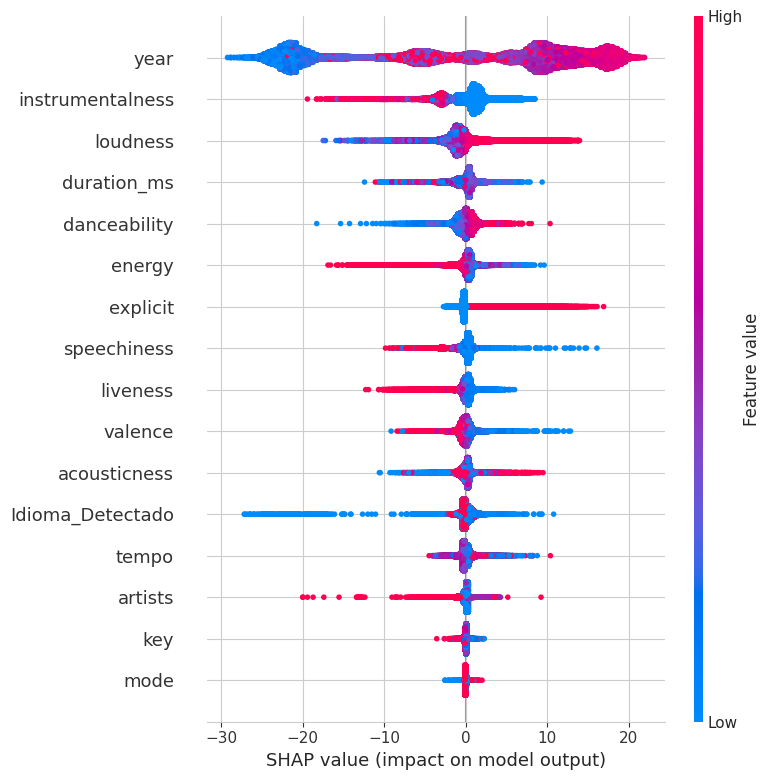

In [ ]:
shap.summary_plot(shap_values, X_train_transformed)

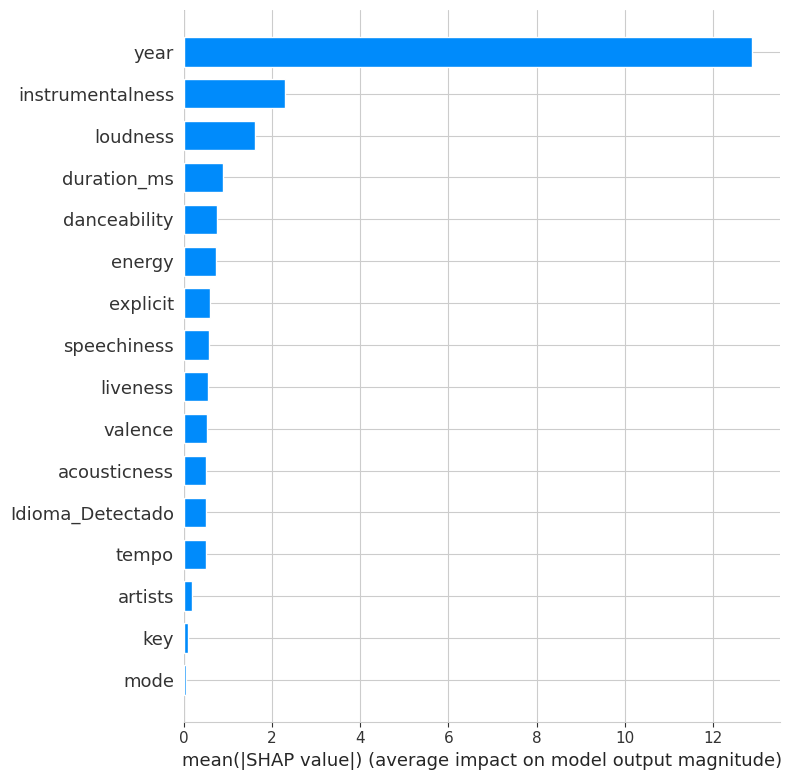

In [ ]:
shap.summary_plot(shap_values, X_train,plot_type='bar')

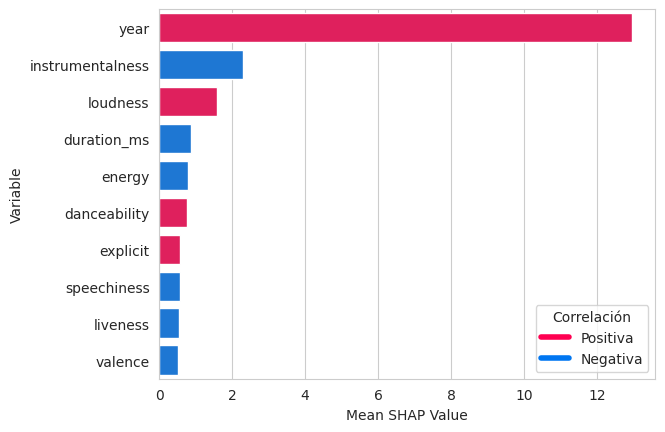

In [ ]:
def ABS_SHAP(df_shap,df):

    shap_v = pd.DataFrame(df_shap.copy())
    shap_v.columns = df.columns
    df_v = df.copy().reset_index().drop('index',axis=1)
    df_v = df_v.astype('float')
    # Determine the correlation in order to plot with different colors
    corr_list = list()
    feature_list = df.columns
    for i in feature_list:
        b = np.corrcoef(shap_v[i],df_v[i])[1][0]
        corr_list.append(b)
    corr_df = pd.concat([pd.Series(feature_list),pd.Series(corr_list)],axis=1).fillna(0)
    # Make a data frame. Column 1 is the feature, and Column 2 is the correlation coefficient
    corr_df.columns  = ['Variable','Corr']
    corr_df['Sign'] = np.where(corr_df['Corr']>0,'#ff0051','#0076f1')

    sns.set_style("whitegrid")

    shap_abs = np.abs(shap_v)
    k=pd.DataFrame(shap_abs.mean()).reset_index()
    k.columns = ['Variable','SHAP_abs']
    k2 = k.merge(corr_df,left_on = 'Variable',right_on='Variable',how='inner')
    k2 = k2.sort_values(by='SHAP_abs',ascending = False).head(10)
    k2.reset_index(inplace=True,drop=True)
    k2['SHAP_abs']=round(k2['SHAP_abs'],2)
    colorlist = k2['Sign']
    ax=sns.barplot(data=k2,y='Variable',x='SHAP_abs',palette=colorlist,)
    ax.set_xlabel("Mean SHAP Value")
    ax.legend([Line2D([0], [0], color='#ff0051', lw=4),Line2D([0], [0], color='#0076f1', lw=4)], ['Positiva', 'Negativa'],title='Correlación')


ABS_SHAP(shap_values.values,X_test_transformed)